# Lab 1: Azure ML experiments
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

In this tutorial, you complete the end-to-end steps to get started with the Azure Machine Learning Python SDK running 
in Jupyter notebooks. 

In this tutorial, you:
- Run some Python code
- Log results and metrics into an Azure ML experiment using run.log
- Save a ML model

> https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture

<img src="https://github.com/retkowsky/images/blob/master/AzureML%20Archi.jpg?raw=true">

> Azure architectures: https://docs.microsoft.com/en-us/azure/architecture/browse/

## 0. Settings

In [1]:
import datetime
today = datetime.datetime.now()
print("Today is", today)

Today is 2021-06-23 09:06:25.053480


In [2]:
import scipy, matplotlib, pandas, sklearn
import numpy as np
import azureml.core
import time
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [3]:
import sys
print("You are using Python", sys.version)

You are using Python 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
print("You are using Azure ML", azureml.core.VERSION)

You are using Azure ML 1.30.0


In [5]:
print("Releases:")
print('- scipy = {}'.format(scipy.__version__))
print('- numpy = {}'.format(np.__version__))
print('- matplotlib = {}'.format(matplotlib.__version__))
print('- pandas = {}'.format(pandas.__version__))
print('- sklearn = {}'.format(sklearn.__version__))
print("- Azure ML =",azureml.core.VERSION)

Releases:
- scipy = 1.5.2
- numpy = 1.18.5
- matplotlib = 3.2.1
- pandas = 0.25.3
- sklearn = 0.22.2.post1
- Azure ML = 1.30.0


> Azure ML Release notes: https://docs.microsoft.com/en-us/azure/machine-learning/azure-machine-learning-release-notes

## Let's connect to the Azure ML workspace

In [6]:
from azureml.core import Workspace

ws = Workspace.from_config()
print('Azure ML Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Azure ML Workspace name: azuremlworkshop2021
Azure region: westeurope
Resource group: azuremlworkshop2021-rg


## 1. Data

In [7]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

In [8]:
# scikit-learn version
import sklearn
print("You are using scikit-learn", sklearn.__version__)

You are using scikit-learn 0.22.2.post1


> https://scikit-learn.org/stable/index.html

#### Data : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [9]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [10]:
# Test population in %
testsizepct=0.30
testsizepct

0.3

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [12]:
nobstrain=len(data['train']['X'])
nobstest=len(data['test']['X'])
nobstotal=nobstrain+nobstest
pcttrain=round(nobstrain/nobstotal*100,2)
pcttest=round(nobstest/nobstotal*100,2)

print ("Training dataset =", nobstrain, 'observations -', pcttrain, '%')
print ("Test dataset =", nobstest, 'observations -', pcttest,'%')

Training dataset = 309 observations - 69.91 %
Test dataset = 133 observations - 30.09 %


## 2. Let's build a model to predict Diabetes level

We will use a **Ridge** regression.<br> 
k is a parameter of this kind of regression model. We will play with multiple values of k during our experiment.
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>

> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html


### Creation of an Azure ML experimentation

In [13]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="Lab1-Experiments")

In [14]:
def regridge(k):
    
    start_time = time.time()
    
    # 1. Starting
    run = experiment.start_logging(snapshot_directory=None)
    
    print('k parameter of the Ridge regression =', k)
    print()    
       
    # 2. Logging
    run.log('k', k) 
    run.log('Test Size', testsizepct)
    run.log('Nobs Training', nobstrain)
    run.log('Nobs Test', nobstest)
    
    print('Test Size =', testsizepct)
    print('Numbers of obs for the Training dataset =', nobstrain)
    print('Number of obs for the Testing dataset =', nobstest)    
    print()
    
    # 3. ML model
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Logging ML metrics
    from sklearn.metrics import r2_score
    import math
    
    mse = round(mean_squared_error(data['test']['y'], preds), 4)
    rmse = round(math.sqrt(mse), 4)
    R2 = round(r2_score(data['test']['y'], preds), 4)
    
    print("Model quality indicators:")
    print('- RMSE =', rmse)
    print('- MSE =', mse)
    print('- R2 =', R2)
    
    run.log("rmse", rmse)
    run.log('mse', mse)
    run.log('R2', R2)

    # 5. Saving the model
    
    model_name = "RegRidgeModele-k-" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    
    joblib.dump(value=regression_model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    
    AMLV=azureml.core.VERSION
    
    # 6. Tags
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", AMLV)
    run.tag("Team", "DataScience France")
    run.tag("Country", "France") 
    run.tag("Author", "Serge") 
    
    # 7. Graph generation
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("RegRidgeGraphique-k-"+str(k)+".png")
    plt.title('Ridge', fontsize=10)
    
    run.log_image(name='My Graph', plot=plt) # Logging the graph into the experiment
    
    print('\nTime elapsed = {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))

    # 6. End
    run.complete()

### Let's call the Python function with different k values

k parameter of the Ridge regression = 0

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

Model quality indicators:
- RMSE = 55.652
- MSE = 3097.1461
- R2 = 0.3929

Time elapsed = 00:00:08


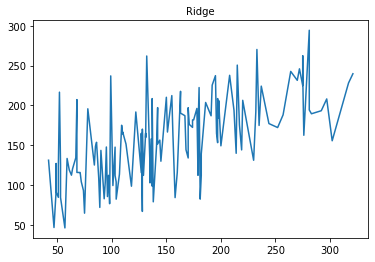

In [15]:
regridge(0)

k parameter of the Ridge regression = 0.1

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

Model quality indicators:
- RMSE = 55.2271
- MSE = 3050.0324
- R2 = 0.4021

Time elapsed = 00:00:06


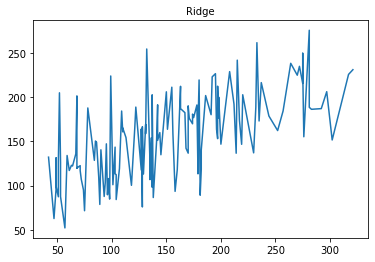

In [16]:
regridge(0.1)

k parameter of the Ridge regression = 0.2

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

Model quality indicators:
- RMSE = 55.0152
- MSE = 3026.6677
- R2 = 0.4067

Time elapsed = 00:00:06


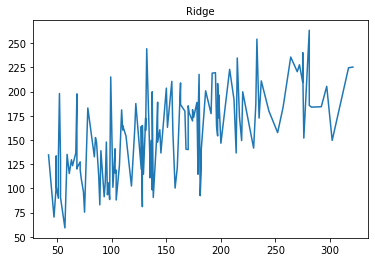

In [17]:
regridge(0.2)

k parameter of the Ridge regression = 0.3

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

Model quality indicators:
- RMSE = 55.0521
- MSE = 3030.7343
- R2 = 0.4059

Time elapsed = 00:00:06


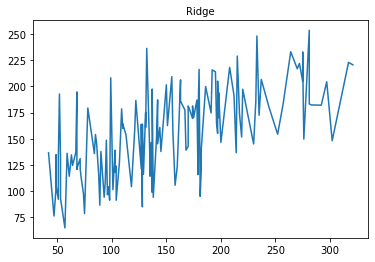

In [18]:
regridge(0.3)

In [19]:
# Viewing the pkl files saved in your compute instance
%ls outputs/RegRidgeModele*.pkl -l

-rwxrwxrwx 1 root root 634 Jun 23 09:06 outputs/RegRidgeModele-k-0.1.pkl*
-rwxrwxrwx 1 root root 634 Jun 23 09:07 outputs/RegRidgeModele-k-0.2.pkl*
-rwxrwxrwx 1 root root 634 Jun 23 09:07 outputs/RegRidgeModele-k-0.3.pkl*
-rwxrwxrwx 1 root root 627 Jun 23 09:06 outputs/RegRidgeModele-k-0.pkl*


In [20]:
# List of the graphs outputs saved in your compute instance
%ls RegRidgeGraphique*.png -l

-rwxrwxrwx 1 root root 24203 Jun 23 09:06 RegRidgeGraphique-k-0.1.png*
-rwxrwxrwx 1 root root 26256 Jun 23 09:07 RegRidgeGraphique-k-0.2.png*
-rwxrwxrwx 1 root root 26623 Jun 23 09:07 RegRidgeGraphique-k-0.3.png*
-rwxrwxrwx 1 root root 24720 Jun 23 09:06 RegRidgeGraphique-k-0.png*


## Let's save the best model into the model repository. All models are versioned.

Best model is for k=0.2 (the RMSE metric has the lowest value)

In [21]:
mymodel='RegRidgeModele-k-0.2.pkl'
k=0.2

RMSE = 55.0152
MSE = 3026.6677
R2 = 0.4067

In [22]:
# Azure ML version
AMLS=azureml.core.VERSION
AMLS

'1.30.0'

In [23]:
from azureml.core.model import Model

model = Model.register(model_path="outputs/"+mymodel, 
                       model_name="DiabetesRidgeModel", 
                       model_framework=Model.Framework.SCIKITLEARN, 
                       model_framework_version='0.22.2',            
                       tags={'dataset': 'Diabetes', 
                             'algorithm': 'Ridge Regression', 
                             'k parameter':k, 
                             'MSE' : MSE, 
                             'R2' : R2,
                             'RMSE' : RMSE,
                             'Framework' : 'Azure ML',
                             'Version Azure ML' : AMLS },
                       description="Ridge regression model to predict diabetes",
                       workspace=ws) 

Registering model DiabetesRidgeModel


## We can retrieve some information about our saved model

In [24]:
model.id

'DiabetesRidgeModel:1'

In [25]:
print('Name :', model.name)
print('Description :', model.description)
print('ID =', model.id)
print('Version =', model.version)

Name : DiabetesRidgeModel
Description : Ridge regression model to predict diabetes
ID = DiabetesRidgeModel:1
Version = 1


In [26]:
model.created_by

{'userObjectId': 'ff4137a8-2d37-4ee7-8675-9876eba469ce',
 'userPuId': '1003200026778A56',
 'userIss': 'https://sts.windows.net/72f988bf-86f1-41af-91ab-2d7cd011db47/',
 'userTenantId': '72f988bf-86f1-41af-91ab-2d7cd011db47',
 'userName': 'Serge Retkowsky'}

In [27]:
model.tags

{'dataset': 'Diabetes',
 'algorithm': 'Ridge Regression',
 'k parameter': '0.2',
 'MSE': '3026.6677',
 'R2': '0.4067',
 'RMSE': '55.0152',
 'Framework': 'Azure ML',
 'Version Azure ML': '1.30.0'}

Now we can see the model into the **Models** section in the Azure ML Studio interface:

In [28]:
experiment

Name,Workspace,Report Page,Docs Page
Lab1-Experiments,azuremlworkshop2021,Link to Azure Machine Learning studio,Link to Documentation


## Let's download the model from the repository and apply it to the test dataset

In [32]:
from azureml.core.model import Model
mymodel = Model(ws, 'DiabetesRidgeModel')
#mymodel = Model(ws, 'DiabetesRidgeModel', version=5) To use a specific release of the model

In [33]:
mymodel

Model(workspace=Workspace.create(name='azuremlworkshop2021', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='azuremlworkshop2021-rg'), name=DiabetesRidgeModel, id=DiabetesRidgeModel:1, version=1, tags={'dataset': 'Diabetes', 'algorithm': 'Ridge Regression', 'k parameter': '0.2', 'MSE': '3026.6677', 'R2': '0.4067', 'RMSE': '55.0152', 'Framework': 'Azure ML', 'Version Azure ML': '1.30.0'}, properties={})

In [34]:
mymodel.version

1

In [35]:
mymodel.id

'DiabetesRidgeModel:1'

In [36]:
mymodel.tags

{'dataset': 'Diabetes',
 'algorithm': 'Ridge Regression',
 'k parameter': '0.2',
 'MSE': '3026.6677',
 'R2': '0.4067',
 'RMSE': '55.0152',
 'Framework': 'Azure ML',
 'Version Azure ML': '1.30.0'}

In [37]:
# Download the pkl file into your local instance
mymodel.download(exist_ok="True")

'RegRidgeModele-k-0.2.pkl'

In [38]:
# We can see the downloaded pkl file
!ls RegRidgeModele-k-0.2.pkl -l

-rwxrwxrwx 1 root root 634 Jun 23 09:09 RegRidgeModele-k-0.2.pkl


## Let's apply the model to the X_test

In [39]:
import joblib
localmodel=joblib.load("RegRidgeModele-k-0.2.pkl")

In [40]:
# Applying the model to the test datasets
localmodel.predict(X_test)

array([225.38288663, 234.75672822, 164.00312819, 123.46281612,
       173.32012984, 240.20150018, 114.66510657, 186.84673729,
       147.81327349, 215.15222333, 157.67496598, 181.29031163,
       114.71860965,  96.35335408, 235.73733821, 102.20957815,
       147.67209551,  75.49004969, 101.20511519, 210.58415103,
       185.33186517, 152.02131114, 160.30359928, 149.58478296,
       197.65520638, 165.07380997, 115.98983757,  91.39581934,
       177.25882651, 164.34061936, 174.33452649,  92.46591384,
       140.53306243, 146.69112715, 149.45576607, 185.73324938,
       163.12555341, 183.86975076, 133.42400217, 196.74441606,
        93.43580034, 169.18689622, 147.92192731, 172.85033475,
       179.93858885,  83.07219651, 136.61675205, 140.33734763,
       132.6680819 , 220.56622016, 157.48518116,  90.73063296,
       154.13365588, 159.89740219, 219.54872002, 177.72397388,
       187.711351  , 115.43236395, 141.66560526, 172.65842486,
       198.06726423, 160.8900295 , 160.64145986, 124.01

In [41]:
import pandas as pd
modelpredictions=pd.DataFrame(localmodel.predict(X_test))

In [42]:
modelpredictions.head(10)

,0
0,225.382887
1,234.756728
2,164.003128
3,123.462816
4,173.320130
5,240.201500
6,114.665107
7,186.846737
8,147.813273
9,215.152223


## We can export the results into a csv file...

In [43]:
modelpredictions.to_csv(r'ModelPredictions.csv', index = False)

In [44]:
!ls ModelPredictions.csv -l

-rwxrwxrwx 1 root root 2481 Jun 23 09:09 ModelPredictions.csv


> You can open now the **Lab2 notebook**.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">